In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/kalpurush-fonts/kalpurush-2.ttf
/kaggle/input/bengaliai-cv19/test_image_data_2.parquet
/kaggle/input/bengaliai-cv19/test_image_data_3.parquet
/kaggle/input/bengaliai-cv19/test_image_data_0.parquet
/kaggle/input/bengaliai-cv19/train.csv
/kaggle/input/bengaliai-cv19/test_image_data_1.parquet
/kaggle/input/bengaliai-cv19/class_map.csv
/kaggle/input/bengaliai-cv19/train_image_data_3.parquet
/kaggle/input/bengaliai-cv19/train_image_data_2.parquet
/kaggle/input/bengaliai-cv19/test.csv
/kaggle/input/bengaliai-cv19/sample_submission.csv
/kaggle/input/bengaliai-cv19/train_image_data_1.parquet
/kaggle/input/bengaliai-cv19/train_image_data_0.parquet
/kaggle/input/bengali-graphemes-croppedresized-100x100-train/train_data_3.feather
/kaggle/input/bengali-graphemes-croppedresized-100x100-train/train_data_1.feather
/kaggle/input/bengali-graphemes-croppedresized-100x100-train/train_data_0.feather
/kaggle/input/bengali-graphemes-croppedresized-100x100-train/train_data_2.feather


In [2]:
class_map = pd.read_csv("../input/bengaliai-cv19/class_map.csv")
train = pd.read_csv("../input/bengaliai-cv19/train.csv")

In [3]:
# Loading first set of images in order to have graphemes samples
train_data = pd.read_parquet('/kaggle/input/bengaliai-cv19/'
                             'train_image_data_0.parquet')
train_data.set_index(keys='image_id', drop=True, inplace=True)

In [4]:
display(train)

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো
...,...,...,...,...,...
200835,Train_200835,22,7,2,র্খে
200836,Train_200836,65,9,0,ত্তো
200837,Train_200837,2,1,4,অ্যা
200838,Train_200838,152,9,0,স্নো


In [5]:
display(class_map)

,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই
...,...,...,...
181,consonant_diacritic,2,র্
182,consonant_diacritic,3,র্য
183,consonant_diacritic,4,্য
184,consonant_diacritic,5,্র


In [6]:
display(train_data)

,0,1,2,3,4,5,6,7,8,9,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
image_id,,,,,,,,,,,,,,,,,,,,,
Train_0,254,253,252,253,251,252,253,251,251,253,...,253,253,253,253,253,253,253,253,253,251
Train_1,251,244,238,245,248,246,246,247,251,252,...,255,255,255,255,255,255,255,255,255,254
Train_2,251,250,249,250,249,245,247,252,252,252,...,254,253,252,252,253,253,253,253,251,249
Train_3,247,247,249,253,253,252,251,251,250,250,...,254,254,254,254,254,253,253,252,251,252
Train_4,249,248,246,246,248,244,242,242,229,225,...,255,255,255,255,255,255,255,255,255,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Train_50205,247,250,250,250,252,250,250,250,251,250,...,246,248,252,252,249,248,250,247,243,243
Train_50206,250,251,250,244,245,243,246,248,246,247,...,255,255,255,255,255,255,255,255,255,253
Train_50207,246,245,246,246,245,245,247,247,245,246,...,247,246,248,246,245,248,249,246,243,245


In [7]:
print('Total number of variables combinations in train set :')
print(len(train.loc[:,['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].drop_duplicates()))

Total number of variables combinations in train set :
1292


# Components repartition

## Global distributions

In [8]:
# Counting number of samples for each root class
root_counts = train['grapheme_root'].value_counts()
display(root_counts.describe())

count     168.000000
mean     1195.476190
std      1257.245597
min       130.000000
25%       336.000000
50%       760.500000
75%      1443.000000
max      5736.000000
Name: grapheme_root, dtype: float64

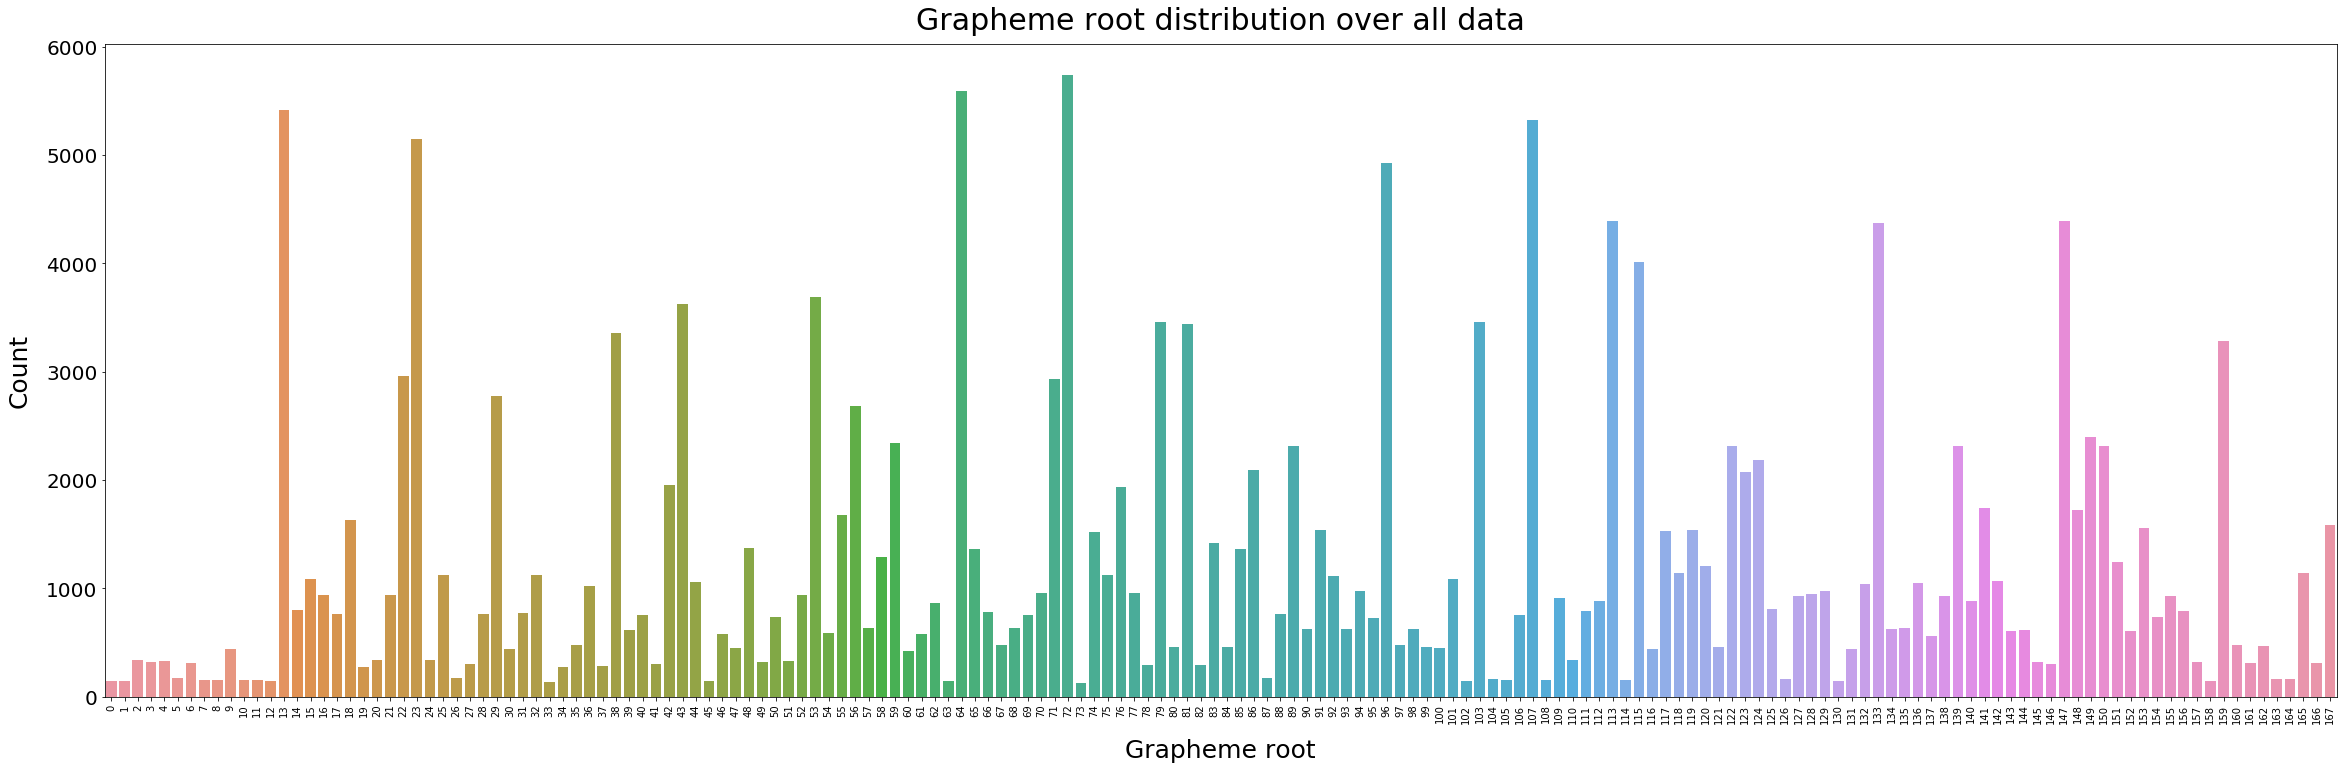

In [9]:
ax, fig = plt.subplots(figsize=(40,12))
ax = sns.barplot(x=root_counts.index, y=root_counts.values);
ax.set_title('Grapheme root distribution over all data', fontsize=30, pad=15)
ax.set_xlabel('Grapheme root', fontsize=25, labelpad=15)
ax.set_ylabel('Count', fontsize=25, labelpad=15)
plt.xticks(fontsize=10, rotation=90);
plt.yticks(fontsize=20);

In [10]:
# Counting number of samples for each vowel class
vowel_counts = train['vowel_diacritic'].value_counts()
display(vowel_counts.describe())

count       11.000000
mean     18258.181818
std      13641.751103
min       3528.000000
25%       4816.500000
50%      16152.000000
75%      27345.000000
max      41508.000000
Name: vowel_diacritic, dtype: float64

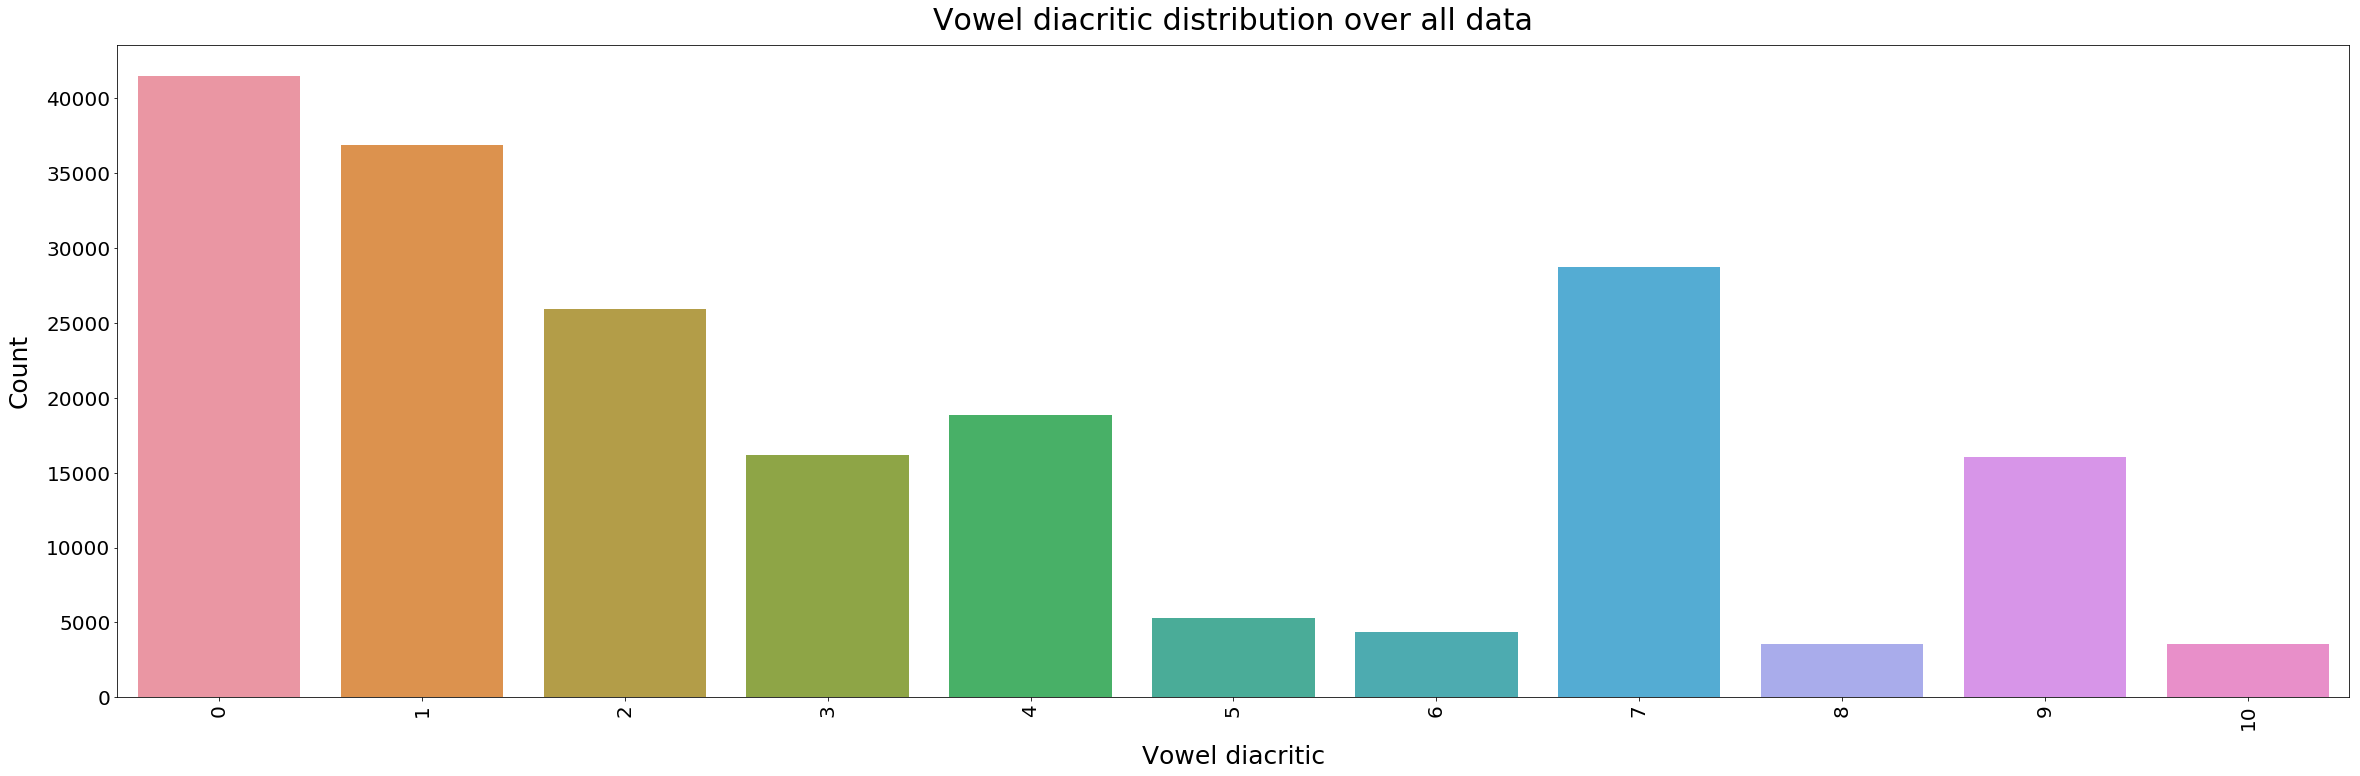

In [11]:
ax, fig = plt.subplots(figsize=(40,12))
ax = sns.barplot(x=vowel_counts.index, y=vowel_counts.values);
ax.set_title('Vowel diacritic distribution over all data', fontsize=30, pad=15)
ax.set_xlabel('Vowel diacritic', fontsize=25, labelpad=15)
ax.set_ylabel('Count', fontsize=25, labelpad=15)
plt.xticks(fontsize=20, rotation=90);
plt.yticks(fontsize=20);

In [12]:
# Counting number of samples for each consonant class
consonant_counts = train['consonant_diacritic'].value_counts()
display(consonant_counts.describe())

count         7.000000
mean      28691.428571
std       43685.360267
min         619.000000
25%        4405.500000
50%       21270.000000
75%       22431.000000
max      125278.000000
Name: consonant_diacritic, dtype: float64

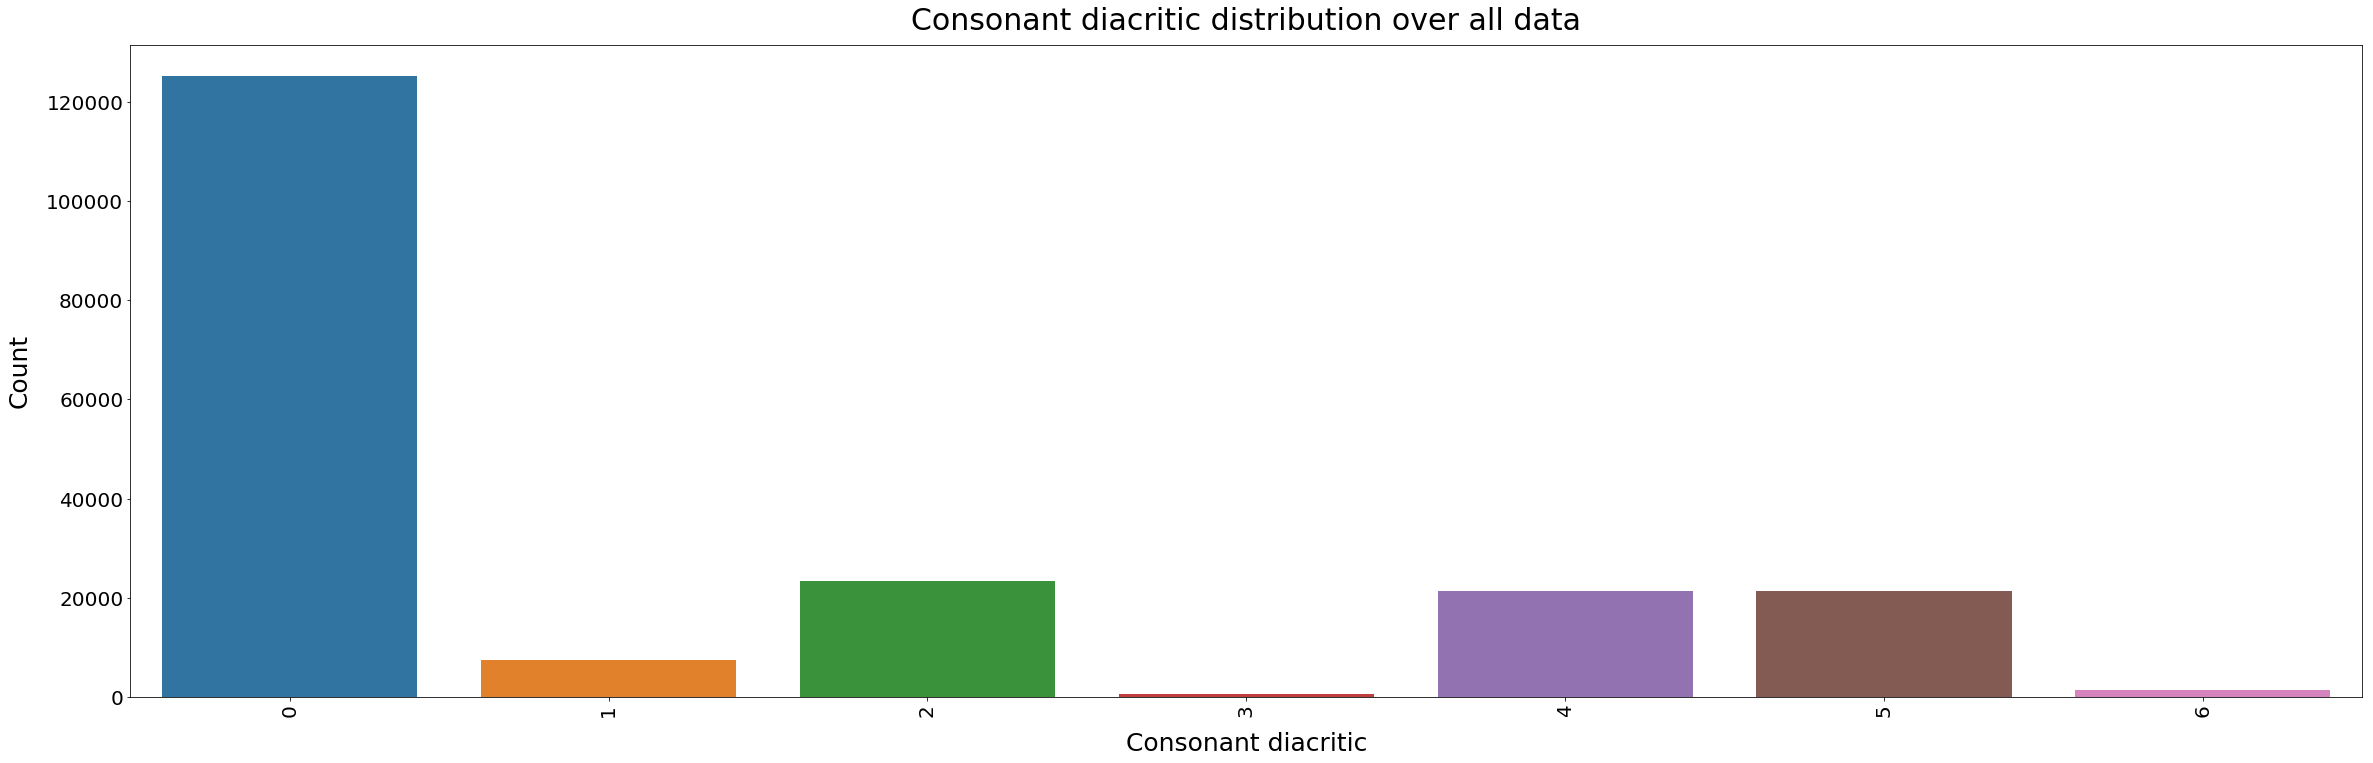

In [13]:
ax, fig = plt.subplots(figsize=(40,12))
ax = sns.barplot(x=consonant_counts.index, y=consonant_counts.values);
ax.set_title('Consonant diacritic distribution over all data', fontsize=30, pad=15)
ax.set_xlabel('Consonant diacritic', fontsize=25, labelpad=15)
ax.set_ylabel('Count', fontsize=25, labelpad=15)
plt.xticks(fontsize=20, rotation=90);
plt.yticks(fontsize=20);

## By set distribution comparison

In [14]:
def compare_set_distribution(df, var):
    
    # Counting number of samples in each set for specific component 'var'
    set_1_distrib = df.loc[:50210,var].value_counts()
    set_1_distrib.sort_index(inplace=True)
    set_2_distrib = df.loc[50210:100420, var].value_counts()
    set_2_distrib.sort_index(inplace=True)
    set_3_distrib = df.loc[100420:150610,var].value_counts()
    set_3_distrib.sort_index(inplace=True)
    set_4_distrib = df.loc[150610:,var].value_counts()
    set_4_distrib.sort_index(inplace=True)
    
    # Calculation of relative distrubtion for set 2, 3 and 4 vs set 1
    relative_distrib_12 = (set_1_distrib - set_2_distrib) / set_1_distrib * 100
    relative_distrib_13 = (set_1_distrib - set_3_distrib) / set_1_distrib * 100
    relative_distrib_14 = (set_1_distrib - set_4_distrib) / set_1_distrib * 100
    
    # Plotting relative distribution of set 2 vs set 1
    fig, (ax0, ax1, ax2) = plt.subplots(3,1, sharex=True, figsize=(45,36))
    sns.barplot(x=relative_distrib_12.index, y=relative_distrib_12.values, ax=ax0);
    ax0.set_title(var + ' distribution set 2 vs 1', fontsize=30, pad=20)
    ax0.set_ylabel('Samples difference (%)', fontsize=30, labelpad=20)
    ax0.tick_params(axis='y',labelsize=25);
    ax0.grid(axis='y', linestyle=':', linewidth=2)
    
    # Plotting relative distribution of set 3 vs set 1
    sns.barplot(x=relative_distrib_13.index, y=relative_distrib_13.values, ax=ax1);
    ax1.set_title(var + ' distribution set 3 vs 1', fontsize=30, pad=20)
    ax1.set_ylabel('Samples difference (%)', fontsize=30, labelpad=20)
    ax1.tick_params(axis='y',labelsize=25);
    ax1.grid(axis='y', linestyle=':', linewidth=2)
    
    # Plotting relative distribution of set 4 vs set 1
    sns.barplot(x=relative_distrib_14.index, y=relative_distrib_14.values, ax=ax2);
    ax2.set_title(var + ' distribution set 4 vs 1', fontsize=30, pad=20)
    ax2.set_xlabel(var, fontsize=30, labelpad=20)
    ax2.set_ylabel('Samples difference (%)', fontsize=30, labelpad=20)
    ax2.tick_params(axis='y', labelsize=25);
    ax2.grid(axis='y', linestyle=':', linewidth=2)
    plt.xticks(rotation=90);

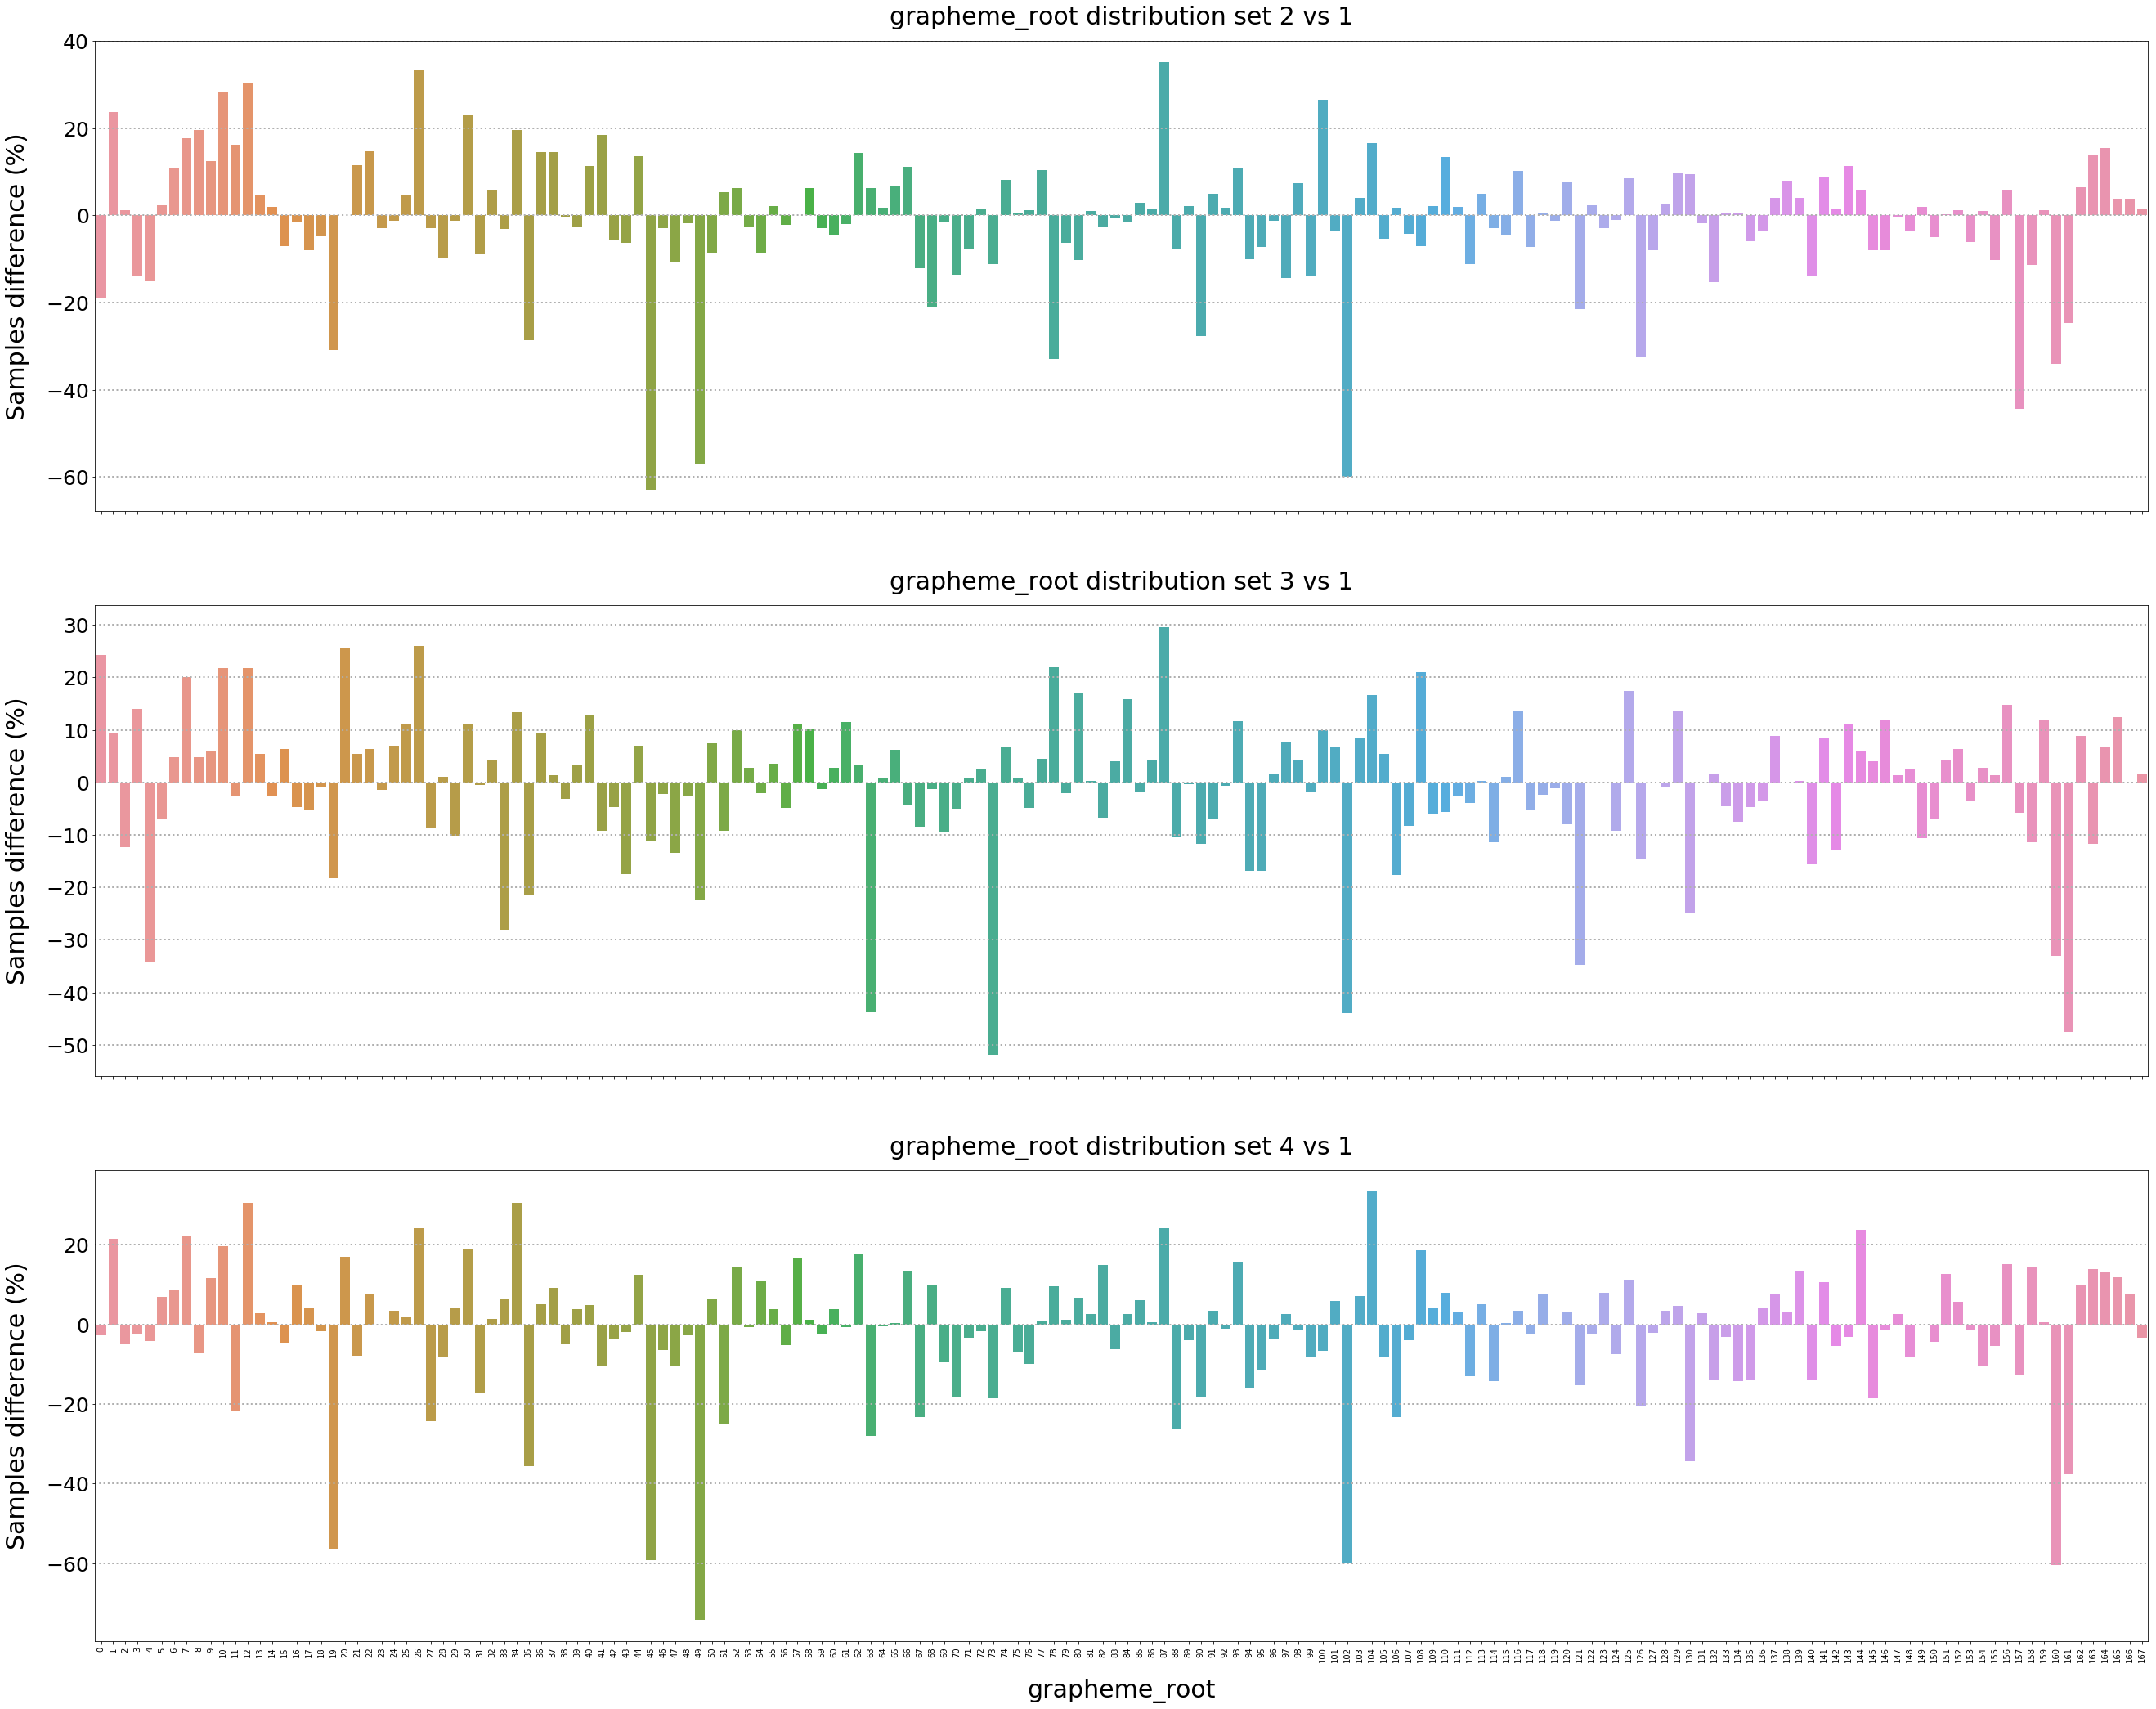

In [15]:
compare_set_distribution(train, 'grapheme_root')

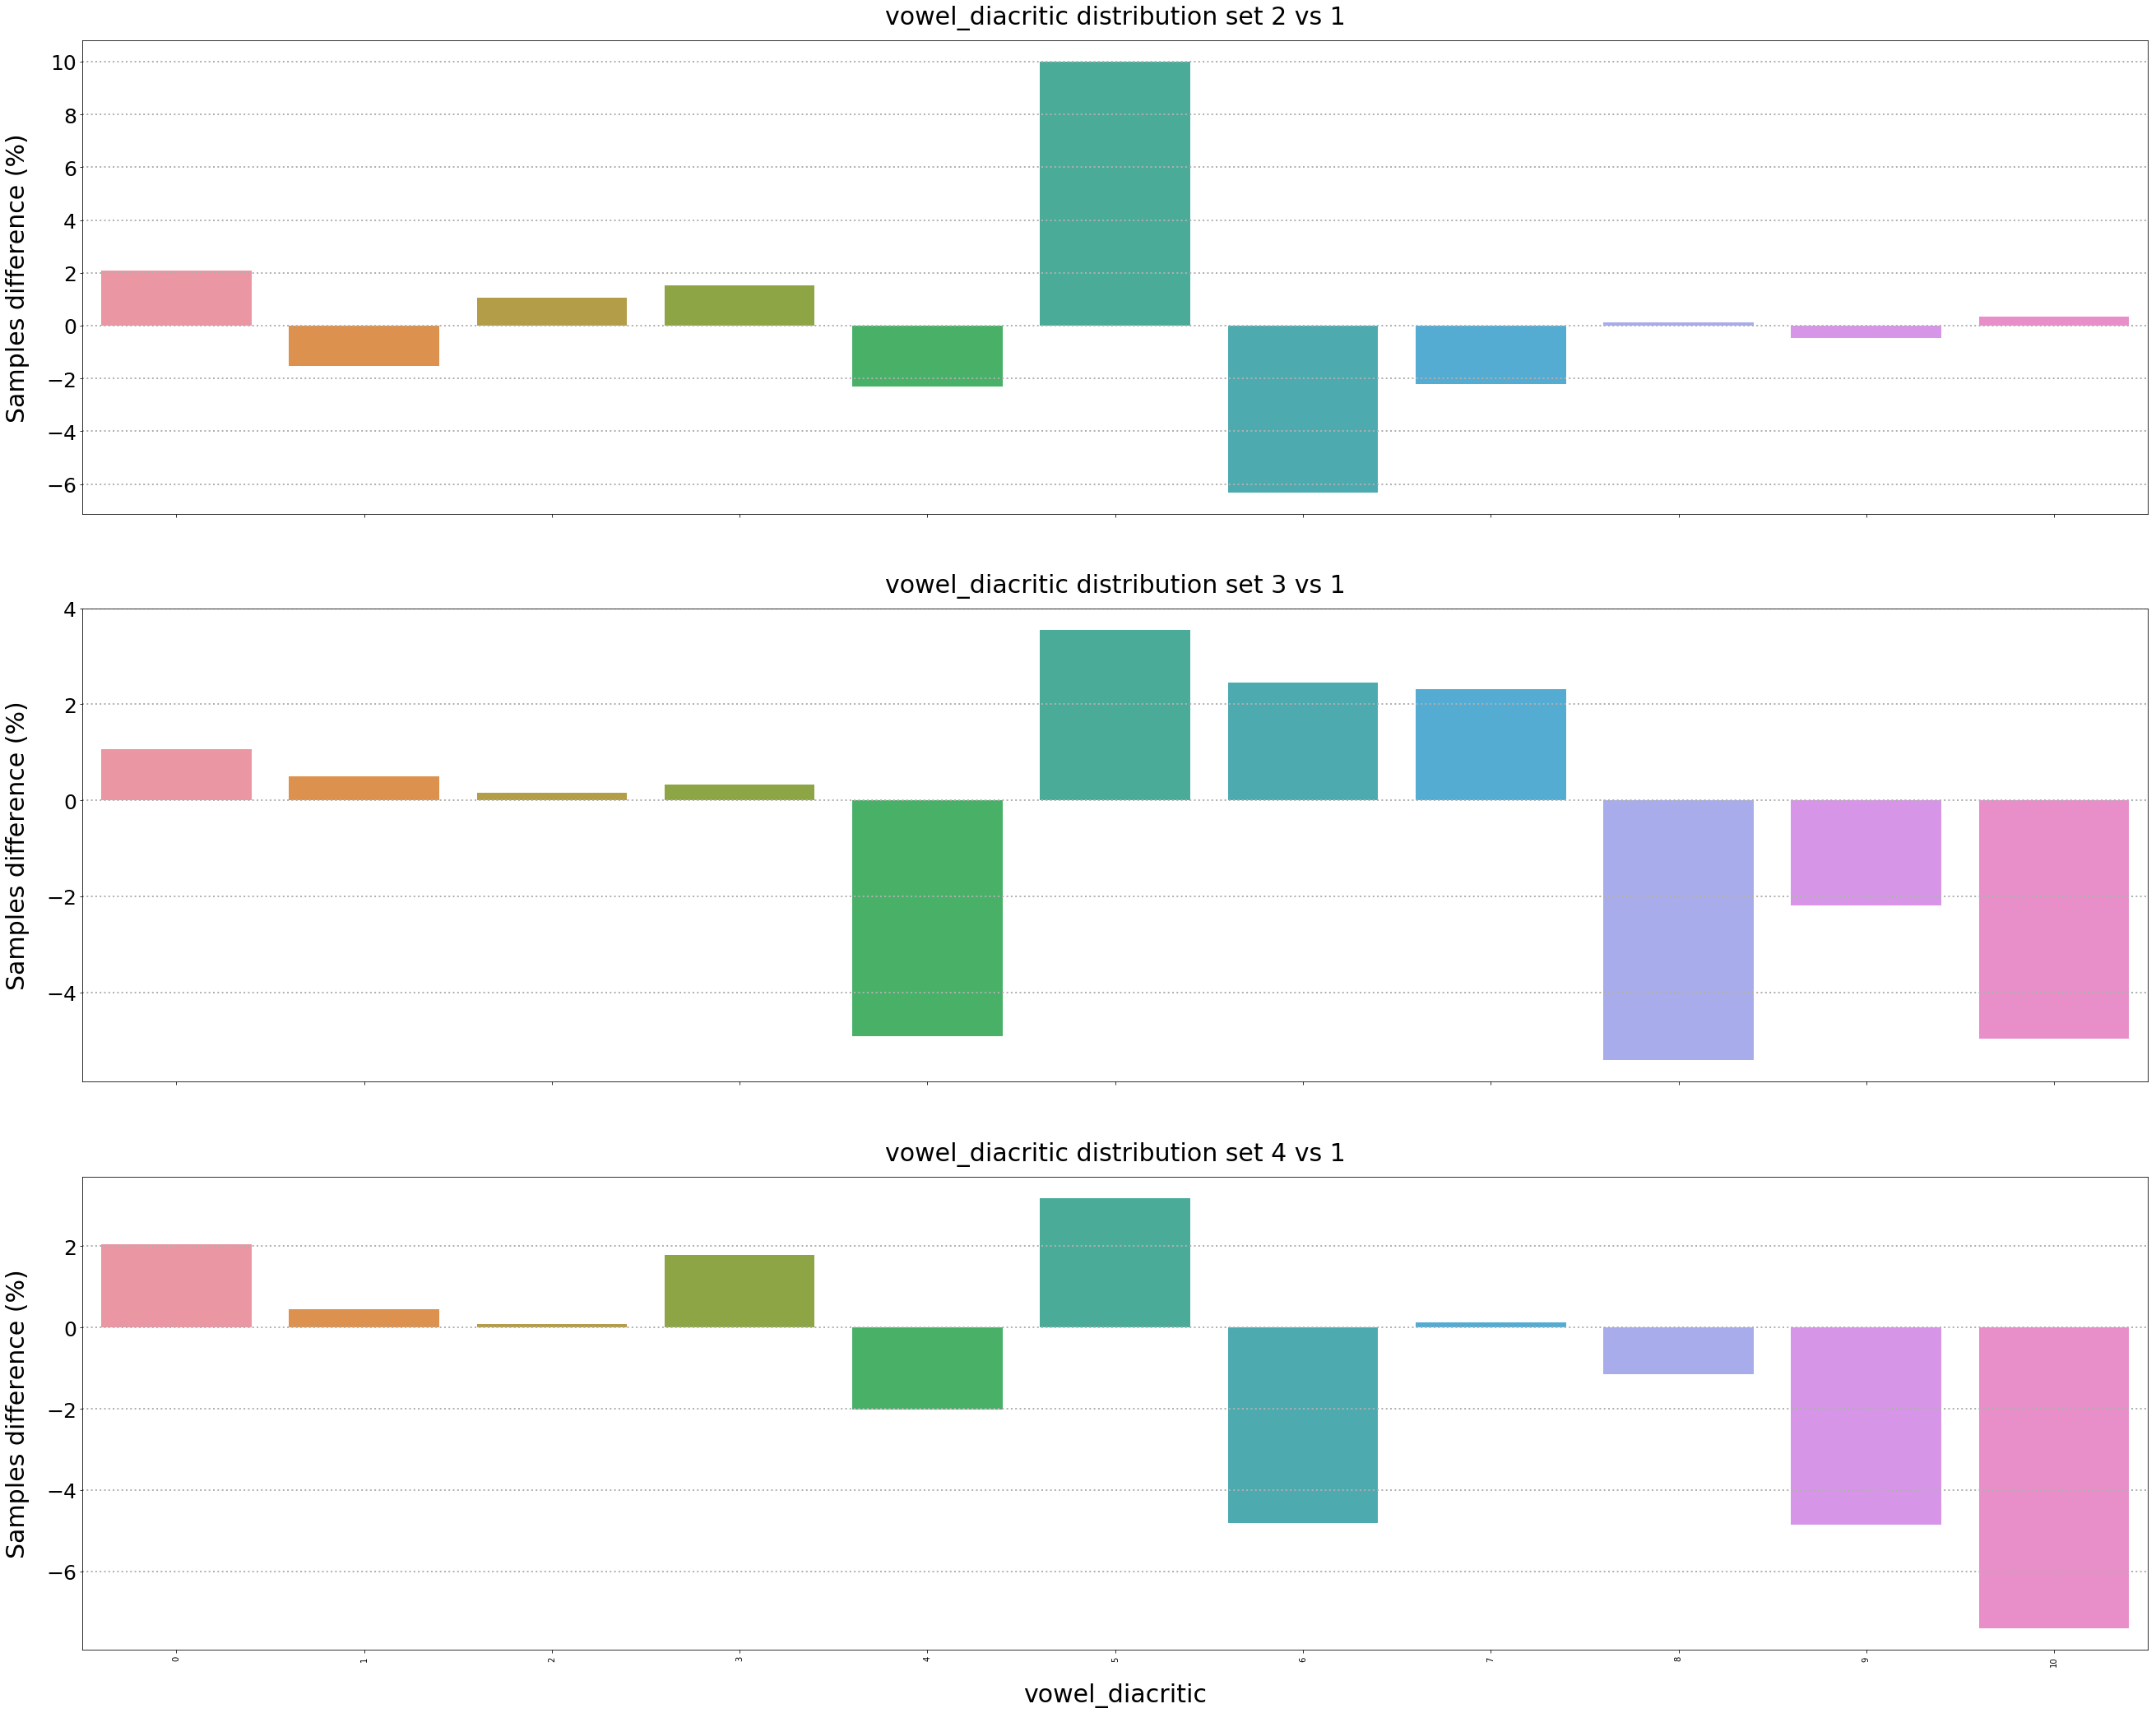

In [16]:
compare_set_distribution(train, 'vowel_diacritic')

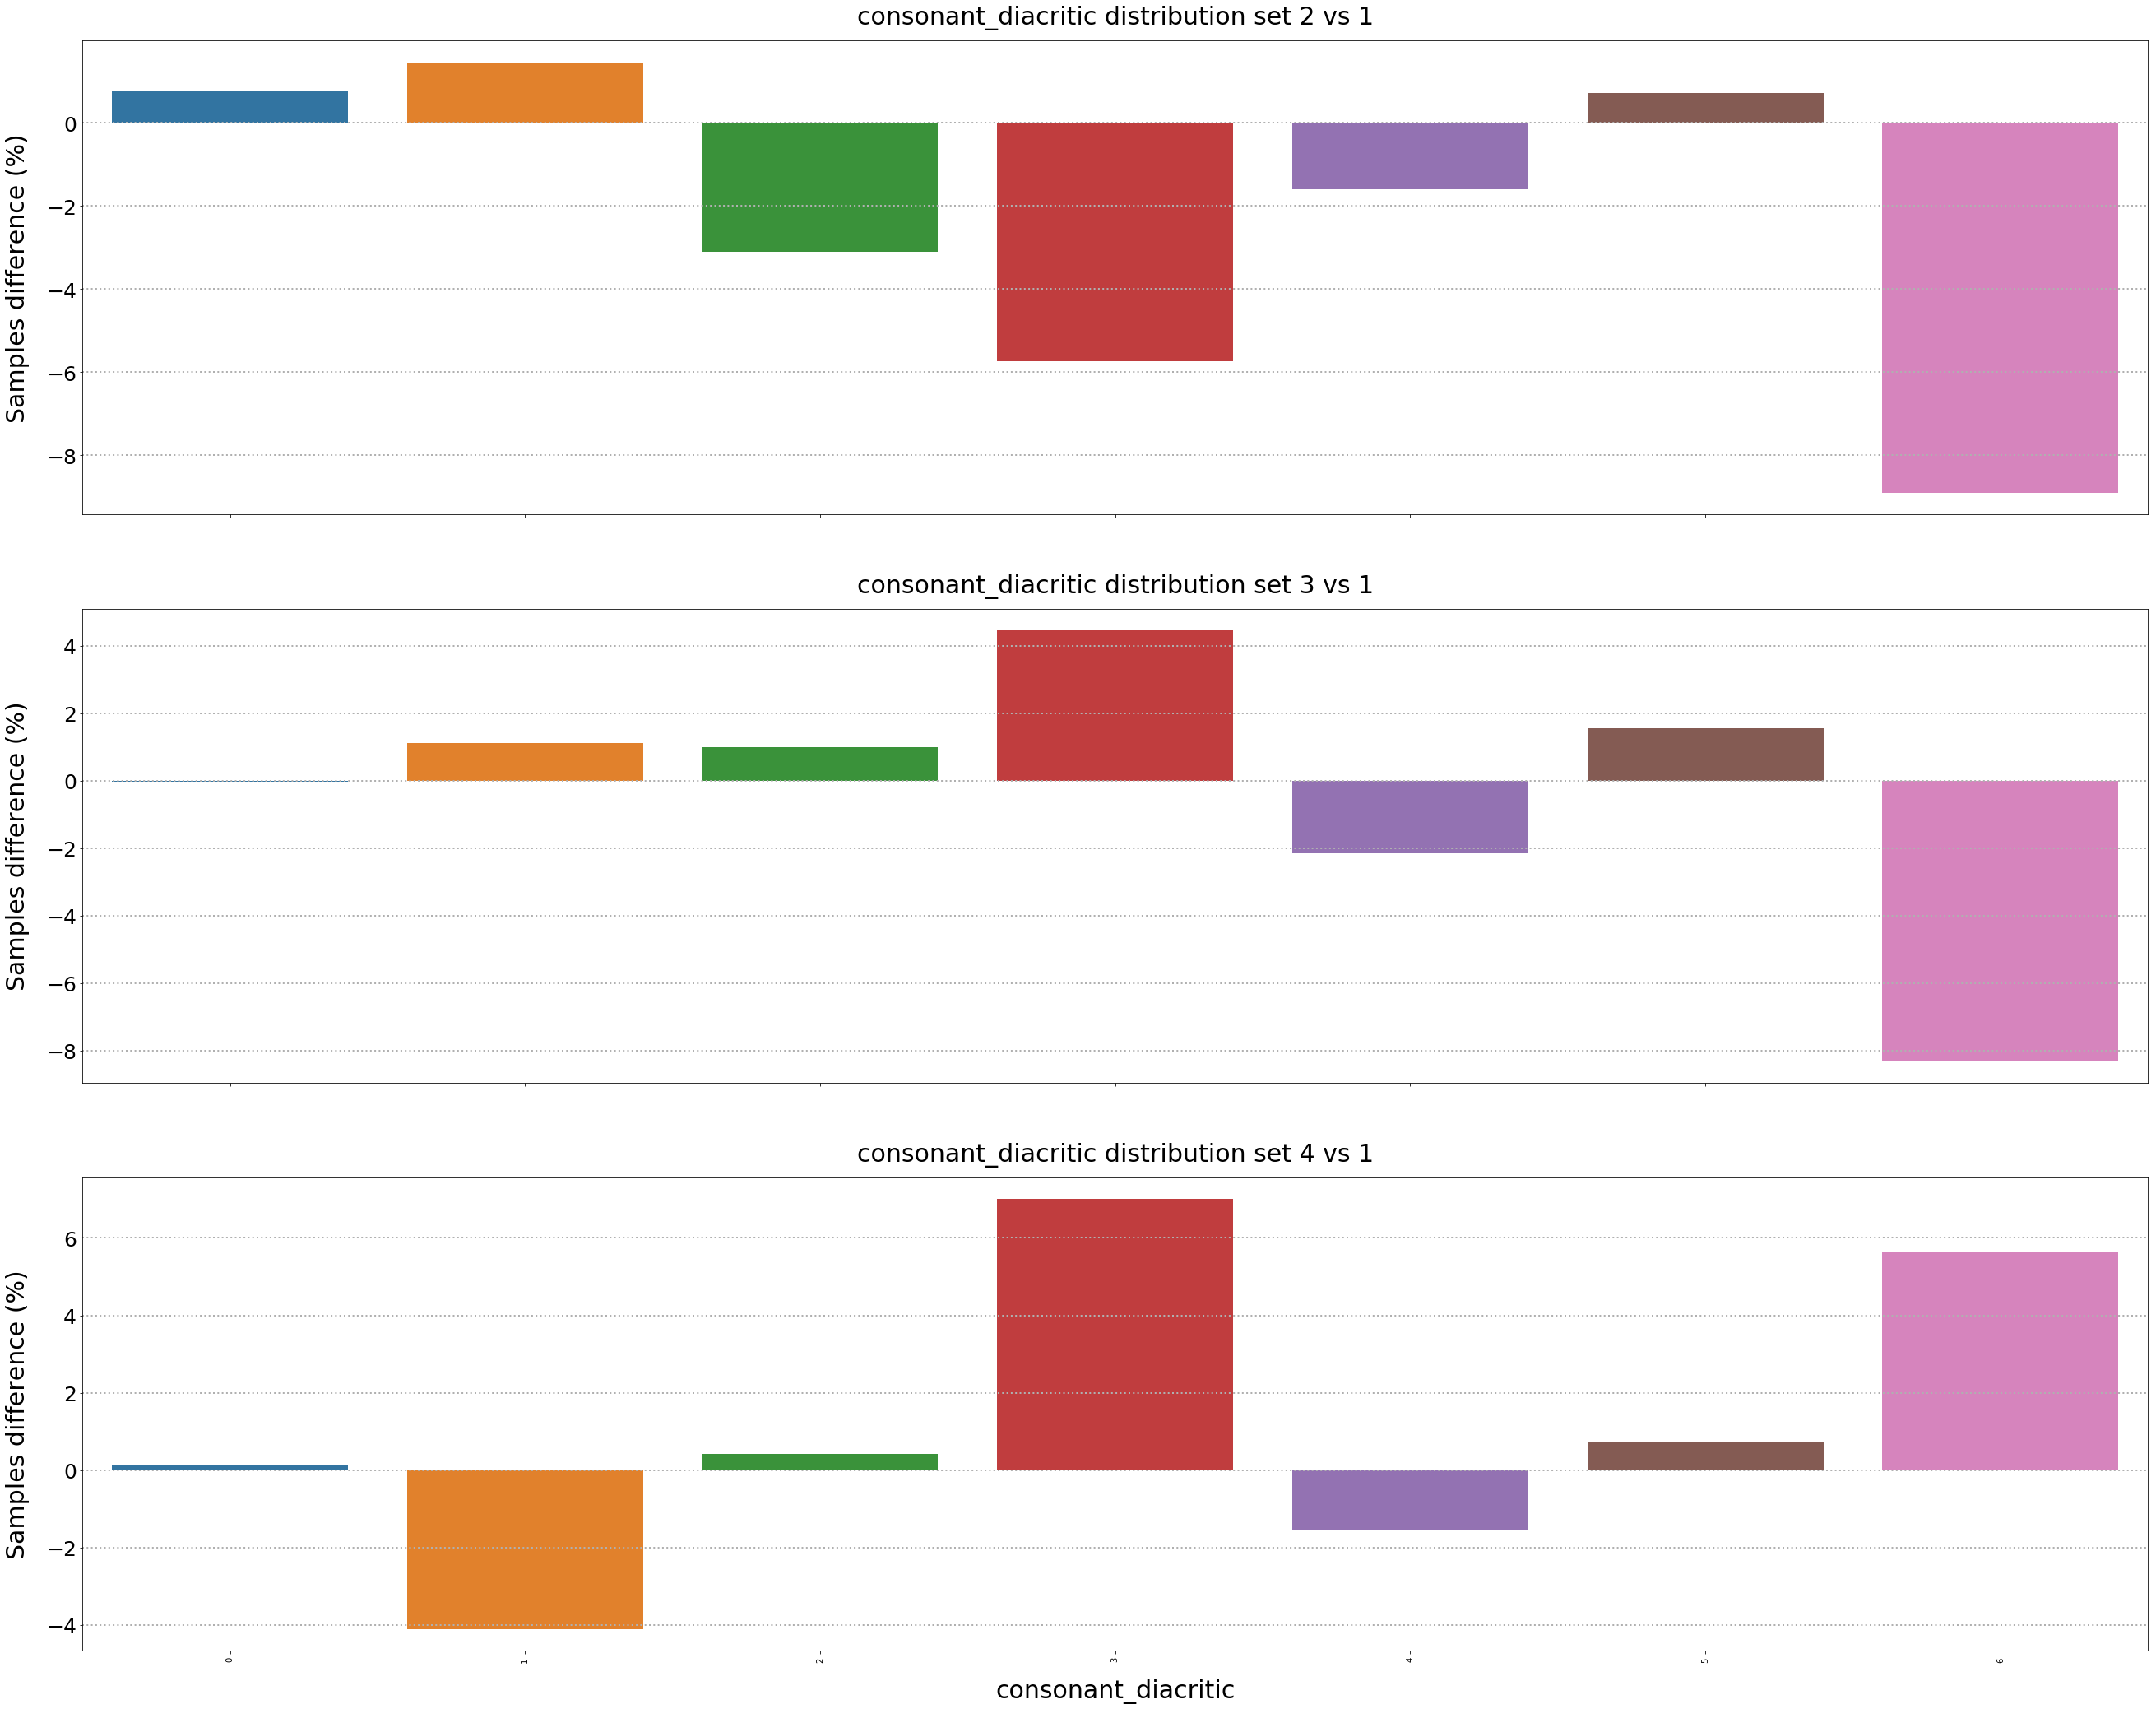

In [17]:
compare_set_distribution(train, 'consonant_diacritic')

# Components visualization

## Visualization from character function

In [18]:
HEIGHT = 236
WIDTH = 236

In [19]:
# Function taking a character as entrance and outputting an image of it
def image_from_char(char):
    image = Image.new('RGB', (WIDTH, HEIGHT))
    draw = ImageDraw.Draw(image)
    myfont = ImageFont.truetype('/kaggle/input/kalpurush-fonts/kalpurush-2.ttf', 120)
    w, h = draw.textsize(char, font=myfont)
    draw.text(((WIDTH - w) / 2,(HEIGHT - h) / 3), char, font=myfont)

    return image

## Most used components :

In [20]:
def display_top_component(component,nb_max):
    
    # Counting number of samples for each class in specific 'component'
    components_count = train[component].value_counts()
    
    # Keeping only 'nb_max' classes with most samples
    top_components = class_map.loc[(class_map['component_type']==component)\
                                    & (class_map['label'].isin(components_count[:nb_max].index))]
    display(top_components)
    
    # Plotting an image for each of X top character in subplot
    f, ax = plt.subplots(round(nb_max/5), 5, figsize=(16, 8))
    ax = ax.flatten()

    for i in range(nb_max):
        ax[i].set_axis_off()
        ax[i].imshow(image_from_char(top_components['component'].iloc[i]), cmap='Greys')
        ax[i].set_title(f'Top {i+1} : label {top_components["label"].iloc[i]}')

,component_type,label,component
13,grapheme_root,13,ক
23,grapheme_root,23,গ
64,grapheme_root,64,ত
72,grapheme_root,72,দ
96,grapheme_root,96,প
107,grapheme_root,107,ব
113,grapheme_root,113,ভ
115,grapheme_root,115,ম
133,grapheme_root,133,শ
147,grapheme_root,147,স


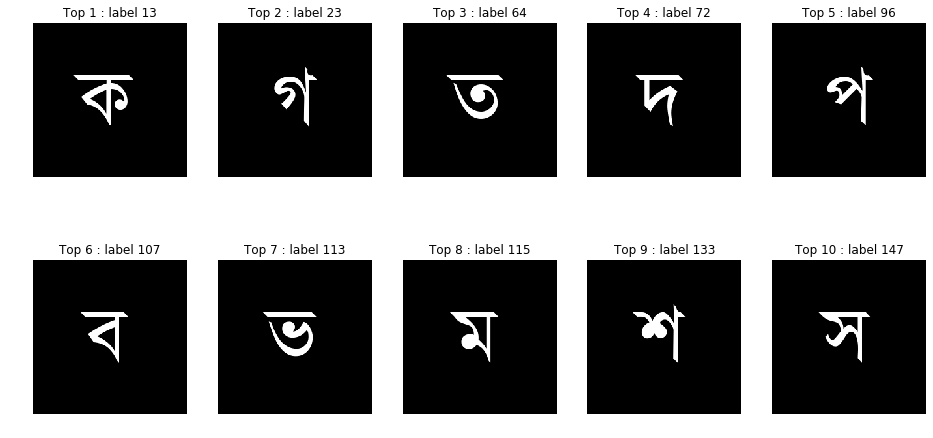

In [21]:
display_top_component('grapheme_root',10)

,component_type,label,component
168,vowel_diacritic,0,0
169,vowel_diacritic,1,া
170,vowel_diacritic,2,ি
172,vowel_diacritic,4,ু
175,vowel_diacritic,7,ে


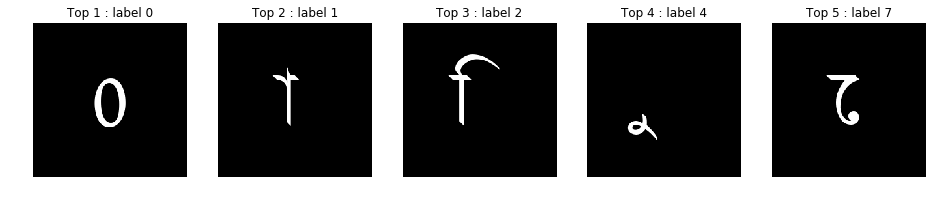

In [22]:
display_top_component('vowel_diacritic',5)

,component_type,label,component
179,consonant_diacritic,0,0
180,consonant_diacritic,1,ঁ
181,consonant_diacritic,2,র্
183,consonant_diacritic,4,্য
184,consonant_diacritic,5,্র


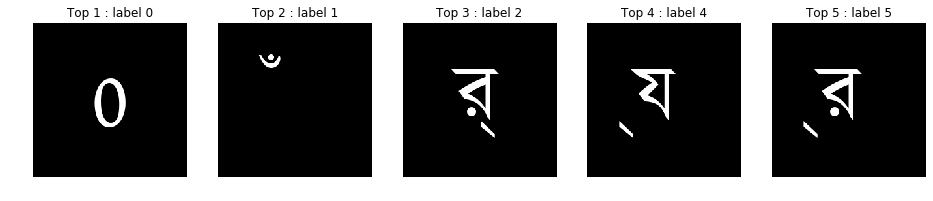

In [23]:
display_top_component('consonant_diacritic',5)

# Exemple of grapheme variants

In [24]:
# Function to display variants of a specific component
def display_component_variant(component_type, component_label):
    
    # Looking for all unique grapheme variants using the specified component
    unique_combination = train.loc[train[component_type]==component_label].copy()
    unique_combination.drop_duplicates(subset=['grapheme_root', 
                                               'vowel_diacritic', 
                                               'consonant_diacritic'], inplace=True)
    unique_combination.reset_index(inplace=True, drop=True)
    
    # Displaying first 2O variants to subplots
    f, ax = plt.subplots(4, 5, figsize=(16, 8))
    ax = ax.flatten()

    for i in range(20):
        ax[i].set_axis_off()
        ax[i].imshow(train_data.loc[unique_combination['image_id'][i],:].values.reshape(137, 236), cmap='Greys')
        ax[i].set_title(f'Image Id : {unique_combination["image_id"][i]}')

## Variants of Root 13

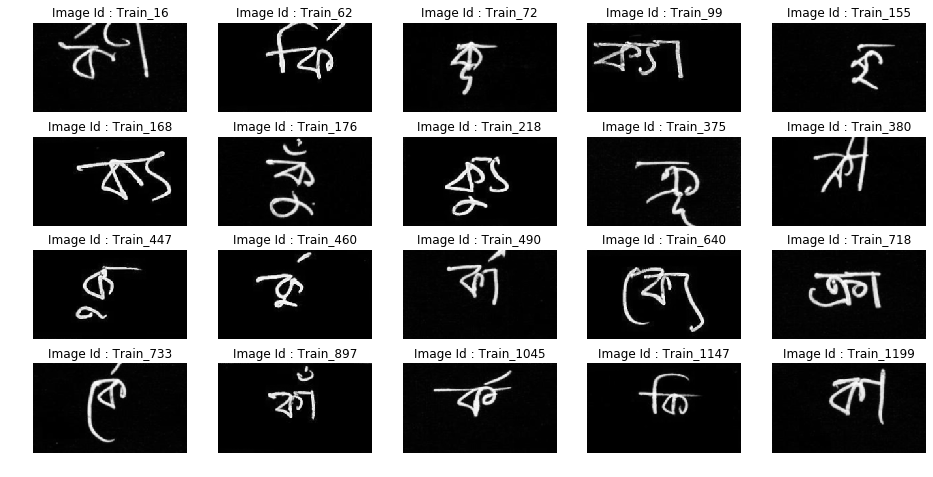

In [25]:
display_component_variant('grapheme_root', 13)

## Variants of Root 64

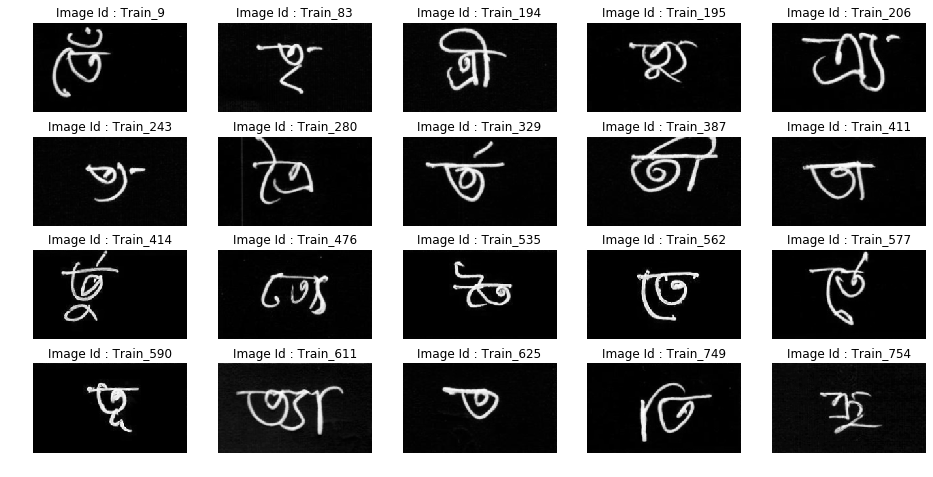

In [26]:
display_component_variant('grapheme_root', 64)